<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter09/Semantic_Segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modified from Modern Computer Vision with PyTorch

In [1]:
import os
import torch
import torch.nn as nn
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Define the Dataset class and create the data loaders 

In [2]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [3]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'./images/semantic-segm/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'./images/semantic-segm/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'./images/semantic-segm/annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [4]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

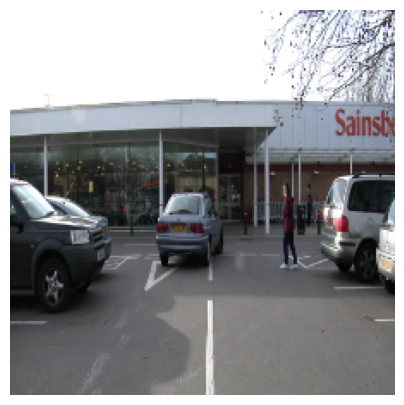

(224, 224, 3)


In [5]:
show(trn_ds[10][0])
print(trn_ds[10][0].shape)

### Define the model using VGG16 for the encoder

In [6]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [7]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [8]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(weights='IMAGENET1K_V1').features
        self.block1 = nn.Sequential(*self.encoder[:6]) 
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)              # image size of the output is 64 x 224 x 224  
        block2 = self.block2(block1)         # image size of the output is 128 x 112 x 112
        block3 = self.block3(block2)         # image size of the output is 256 x 56 x 56
        block4 = self.block4(block3)         # image size of the output is 512 x 28 x 28
        block5 = self.block5(block4)         # image size of the output is 512 x 14 x 14

        bottleneck = self.bottleneck(block5) # image size of the output is 512 x 7 x 7
        x = self.conv_bottleneck(bottleneck) # image size of the output is 1024 x 7 x 7
        
        x = self.up_conv6(x)                 # image size of the output is 512 x 14 x 14          
        x = torch.cat([x, block5], dim=1)    # image size of the output is 1024 x 14 x 14 
        x = self.conv6(x)                    # image size of the output is 512 x 14 x 14 
    
        x = self.up_conv7(x)                 # image size of the output is 256 x 28 x 28
        x = torch.cat([x, block4], dim=1)    # image size of the output is 768 x 28 x 28 
        x = self.conv7(x)                    # image size of the output is 256 x 28 x 28
    
        
        x = self.up_conv8(x)                 # image size of the output is 128 x 56 x 56
        x = torch.cat([x, block3], dim=1)    # image size of the output is 384 x 28 x 28
        x = self.conv8(x)                    # image size of the output is 128 x 56 x 56 
        
        x = self.up_conv9(x)                 # image size of the output is 64 x 112 x 112
        x = torch.cat([x, block2], dim=1)    # image size of the output is 192 x 112 x 112
        x = self.conv9(x)                    # image size of the output is 64 x 112 x 112
        
        x = self.up_conv10(x)                # image size of the output is 32 x 224 x 224
        x = torch.cat([x, block1], dim=1)    # image size of the output is 96 x 224 x 224
        x = self.conv10(x)                   # image size of the output is 32 x 224 x 224

        x = self.conv11(x)                   # image size of the output is 12 classes x 224 x 224

        return x

### Define the loss function

In [9]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

### Define the training and validation functions

In [10]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

### Create the model and define its hiperparameters

In [11]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs  = 20
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
      BatchNorm2d-10         [-1, 64, 224, 224]             128
             ReLU-11         [-1, 64, 224, 224]               0
             ReLU-12         [-1, 64, 224, 224]               0
        MaxPool2d-13         [-1, 64, 112, 112]               0
        MaxPool2d-14         [-1, 64, 1

### Train and evaluate the model

In [12]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    if (ex+1) % 10: log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 0.942  val_acc: 0.719  trn_loss: 1.078  trn_acc: 0.763  (14.71s - 279.41s remaining)
EPOCH: 2.000  val_loss: 0.563  val_acc: 0.858  trn_loss: 0.670  trn_acc: 0.824  (24.08s - 216.76s remaining)
EPOCH: 3.000  val_loss: 0.596  val_acc: 0.817  trn_loss: 0.562  trn_acc: 0.848  (33.44s - 189.51s remaining)
EPOCH: 4.000  val_loss: 0.561  val_acc: 0.842  trn_loss: 0.493  trn_acc: 0.865  (43.31s - 173.26s remaining)
EPOCH: 5.000  val_loss: 0.583  val_acc: 0.827  trn_loss: 0.451  trn_acc: 0.875  (52.97s - 158.90s remaining)
EPOCH: 6.000  val_loss: 0.468  val_acc: 0.854  trn_loss: 0.439  trn_acc: 0.876  (62.48s - 145.79s remaining)
EPOCH: 7.000  val_loss: 0.490  val_acc: 0.845  trn_loss: 0.398  trn_acc: 0.887  (71.80s - 133.34s remaining)
EPOCH: 8.000  val_loss: 0.552  val_acc: 0.822  trn_loss: 0.381  trn_acc: 0.891  (81.42s - 122.14s remaining)
EPOCH: 9.000  val_loss: 0.390  val_acc: 0.873  trn_loss: 0.351  trn_acc: 0.899  (90.77s - 110.94s remaining)
EPOCH: 11.000  val_

### Report the results

100%|███████████████████████████████████████| 121/121 [00:00<00:00, 2392.74it/s]


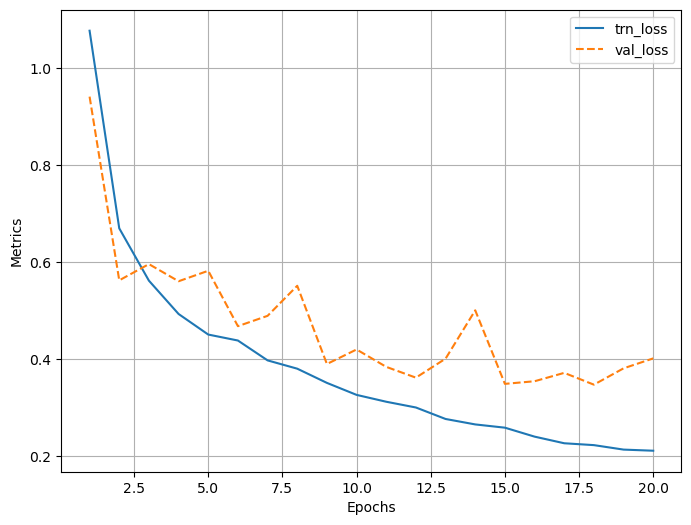

100%|███████████████████████████████████████| 121/121 [00:00<00:00, 2422.14it/s]


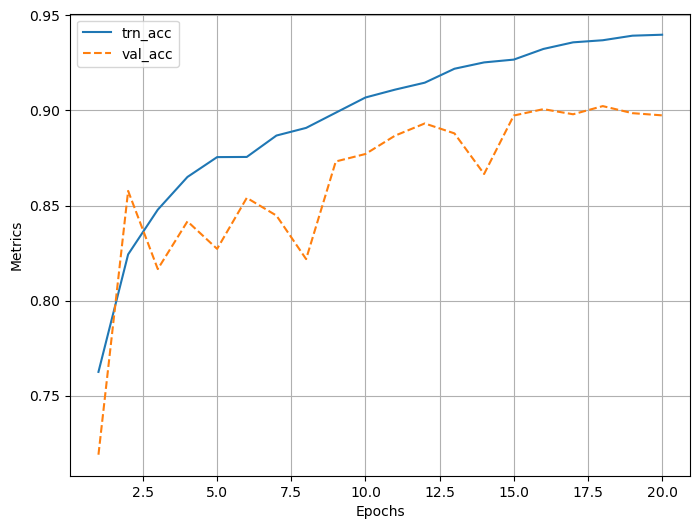

In [13]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Deploy the model in images of the validation set

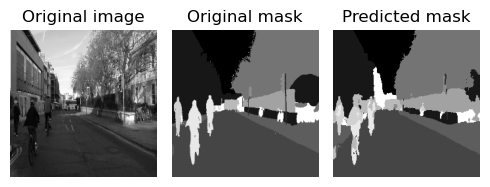

In [14]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])